## Import Libraries

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
import torch
import torch.nn as nn 

## EDA

In [ ]:
df = pd.read_csv("NYCTaxiFares.csv")

In [ ]:
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [ ]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [ ]:
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude')



In [ ]:
df.head(3)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [ ]:
my_time = df['pickup_datetime'][0]

my_time.hour

8

In [ ]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [ ]:
df['Hour'] = df['EDTdate'].dt.hour

In [ ]:
df['AM_PM'] = np.where(df['Hour'] < 12, 'am', 'pm')

In [ ]:
df.head(4)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AM_PM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm


In [ ]:
df['Weekday'] = df['EDTdate'].dt.strftime('%a')

df.sample(3)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AM_PM,Weekday
93536,2010-04-23 03:32:00+00:00,3.7,0,-73.914228,40.759975,-73.921308,40.756207,2,0.728803,2010-04-22 23:32:00+00:00,23,pm,Thu
38838,2010-04-24 10:40:00+00:00,3.7,0,-73.974542,40.791128,-73.979093,40.785287,1,0.754080,2010-04-24 06:40:00+00:00,6,am,Sat
116917,2010-04-21 13:25:09+00:00,13.3,1,-73.990566,40.756219,-73.954544,40.789827,1,4.813176,2010-04-21 09:25:09+00:00,9,am,Wed


In [ ]:
earliest_hour = df['EDTdate'].min()
latest_hour = df['EDTdate'].max()

print(earliest_hour)
print(latest_hour)

2010-04-11 00:00:10+00:00
2010-04-24 23:59:42+00:00


## Categorical and Continuos Features

In [ ]:
# Categorical columns
cat_cols = ['Hour', 'AM_PM', 'Weekday']

# Continuos columns
cont_cols = ['pickup_longitude', 'pickup_latitude', 
             'dropoff_longitude', 'dropoff_latitude',
             'passenger_count', 'dist_km']

In [ ]:
y_col = ['fare_amount']

In [ ]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AM_PM                             object
Weekday                           object
dtype: object

In [ ]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [ ]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AM_PM                           category
Weekday                         category
dtype: object

In [ ]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [ ]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [ ]:
df['AM_PM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [ ]:
hr = df['Hour'].cat.codes.values
ampm = df['AM_PM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values 

In [ ]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [ ]:
ampm

array([0, 0, 0, ..., 1, 0, 1], dtype=int8)

In [ ]:
wkdy

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [ ]:
cats = np.stack([hr,ampm, wkdy], axis=1)
cats 

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [ ]:
cats[0] # at 4(hour) am( 0 means AM) on monday(1)

array([4, 0, 1], dtype=int8)

In [ ]:
# one line for categorical datas 
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [ ]:
cats = torch.tensor(cats, dtype=torch.int64)

In [ ]:
conts = np.stack([df[col].values for col in cont_cols], axis = 1)

In [ ]:
# Convert continuos data to tensor 
conts = torch.tensor(conts, dtype=torch.float)

In [ ]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [ ]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

In [ ]:
# categorical data
cats.shape

torch.Size([120000, 3])

In [ ]:
# continuous data
conts.shape

torch.Size([120000, 6])

In [ ]:
# label 
y.shape

torch.Size([120000, 1])

## Embedding 

In [ ]:
# Define sizes 
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [ ]:
# [total of hour in a day, am and pm (2 categories), 7 days in a week]
cat_szs

[24, 2, 7]

In [ ]:
# get a size element and divide by 2 or give 50 
emb_szs = [(size,(min(50,size+1)//2)) for size in cat_szs]

In [ ]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

### Tabular Model

#### Breakdown 

In [ ]:
# sub set data
cat_sample = cats[:2]

cat_sample

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [ ]:
# model 
selembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])

selembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [ ]:
# Forward method for (cat_sample)
embeddingz = []

for i,e in enumerate(selembeds):
  embeddingz.append(e(cat_sample[:,i]))

In [ ]:
embeddingz

[tensor([[-1.1712, -1.0707,  1.5110, -1.4429, -0.3396, -1.6925, -0.3451,  1.3243,
           0.1380, -0.7729,  0.9246,  0.5713],
         [ 0.4214,  0.9682, -0.9452,  1.9558,  0.9899,  1.0497,  1.0668, -1.0889,
          -1.4327, -2.1288, -0.0278, -0.6627]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.0216],
         [-0.0216]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.4373, -0.7895,  1.2179,  0.4470],
         [ 1.6881, -1.5008, -1.5567,  0.5621]], grad_fn=<EmbeddingBackward>)]

In [ ]:
 z = torch.cat(embeddingz,1)
 z

tensor([[-1.1712, -1.0707,  1.5110, -1.4429, -0.3396, -1.6925, -0.3451,  1.3243,
          0.1380, -0.7729,  0.9246,  0.5713, -0.0216,  0.4373, -0.7895,  1.2179,
          0.4470],
        [ 0.4214,  0.9682, -0.9452,  1.9558,  0.9899,  1.0497,  1.0668, -1.0889,
         -1.4327, -2.1288, -0.0278, -0.6627, -0.0216,  1.6881, -1.5008, -1.5567,
          0.5621]], grad_fn=<CatBackward>)

In [ ]:
selfembdrop = nn.Dropout(0.4)


In [ ]:
z = selfembdrop(z)

z

tensor([[-1.9521, -1.7846,  0.0000, -2.4048, -0.0000, -2.8208, -0.0000,  0.0000,
          0.2299, -1.2882,  0.0000,  0.0000, -0.0000,  0.7289, -0.0000,  2.0298,
          0.7450],
        [ 0.7023,  0.0000, -0.0000,  3.2596,  1.6499,  1.7495,  0.0000, -1.8149,
         -0.0000, -3.5480, -0.0000, -1.1045, -0.0359,  0.0000, -0.0000, -2.5945,
          0.0000]], grad_fn=<MulBackward0>)

### Create TabularModel

In [ ]:
class TabularModel(nn.Module):

  def __init__(self, emb_szs, n_cont, output_size, layers, p=0.5):
    
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(p) 
    self.bn_cont = nn.BatchNorm1d(n_cont)

    layerlist = []
    n_emb = sum([nf for ni, nf in emb_szs])
    n_in = n_emb + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in, i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i

    layerlist.append(nn.Linear(layers[-1], output_size))

    self.layers= nn.Sequential(*layerlist)


  def forward(self, x_cat, x_cont):

    embeddings = []
    
    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:,i]))

    x = torch.cat(embeddings,1)
    x = self.emb_drop(x)
    
    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)
    x = self.layers(x)

    return x

## Training and Evaluation 

In [ ]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [ ]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [ ]:
# Data already shuffled 

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

In [ ]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
len(cat_train)

48000

In [ ]:
len(cont_train)

48000

### Train

In [ ]:
import time 

star_time = time.time()

epochs = 500 

losses = []


for i in range(epochs):
  i += 1 

  y_pred = model(cat_train, cont_train)
  loss = torch.sqrt(criterion(y_pred, y_train))
  losses.append(loss)

  if i%10==1:
    print("epoch:{} loss:{}".format(i, loss))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

duration = time.time() - star_time

print("Training Duration: {}".format(duration/60))

epoch:1 loss:9.176569938659668
epoch:11 loss:8.8915376663208
epoch:21 loss:8.574092864990234
epoch:31 loss:8.21468734741211
epoch:41 loss:7.812304973602295
epoch:51 loss:7.381375312805176
epoch:61 loss:6.920572280883789
epoch:71 loss:6.447566032409668
epoch:81 loss:5.972303867340088
epoch:91 loss:5.484586715698242
epoch:101 loss:5.018704414367676
epoch:111 loss:4.650603771209717
epoch:121 loss:4.309920310974121
epoch:131 loss:4.070165634155273
epoch:141 loss:3.9556121826171875
epoch:151 loss:3.87135910987854
epoch:161 loss:3.8176746368408203
epoch:171 loss:3.789914608001709
epoch:181 loss:3.7474453449249268
epoch:191 loss:3.724388837814331
epoch:201 loss:3.6845436096191406
epoch:211 loss:3.624664783477783
epoch:221 loss:3.651637315750122
epoch:231 loss:3.6048967838287354
epoch:241 loss:3.6228535175323486
epoch:251 loss:3.5918002128601074
epoch:261 loss:3.5534207820892334
epoch:271 loss:3.5484776496887207
epoch:281 loss:3.5442357063293457
epoch:291 loss:3.502241611480713
epoch:301 loss:

### Evaluation

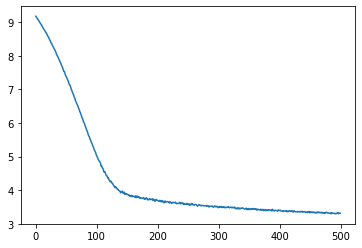

In [ ]:
plt.plot(range(epochs),losses)

In [ ]:
with torch.no_grad():
  y_val = model(cat_test,cont_test)

  loss = torch.sqrt(criterion(y_val, y_test))

In [ ]:
loss

tensor(3.2534)

In [ ]:
for i in range(10):
  print("{}) Predicted: {:.4f} True Value: {:.4f}".format(i,y_val[i].item(), y_test[i].item()))

0) Predicted: 3.6825 True Value: 2.9000
1) Predicted: 22.8727 True Value: 5.7000
2) Predicted: 7.7183 True Value: 7.7000
3) Predicted: 9.5880 True Value: 12.5000
4) Predicted: 5.5305 True Value: 4.1000
5) Predicted: 5.0380 True Value: 5.3000
6) Predicted: 4.3241 True Value: 3.7000
7) Predicted: 16.4287 True Value: 14.5000
8) Predicted: 3.8438 True Value: 5.7000
9) Predicted: 11.9525 True Value: 10.1000


In [ ]:
torch.save(model.state_dict(),'TaxiFaresModel.pt')